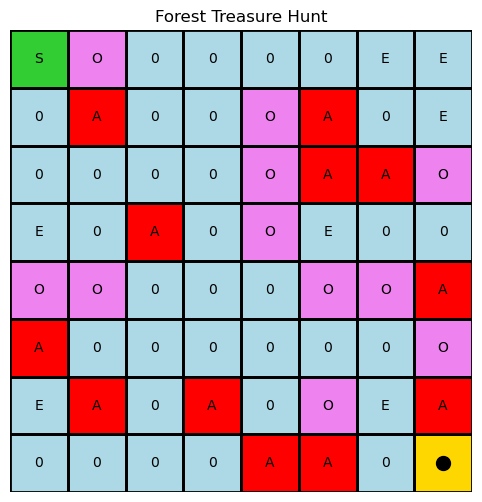

Optimal path for UCS: 
At (6, 0): Cost encountered: 1, Entity: 0
At (5, 0): Cost encountered: 1, Entity: 0
At (5, 1): Cost encountered: 1, Entity: 0
At (5, 2): Cost encountered: 1, Entity: 0
At (5, 3): Cost encountered: 1, Entity: 0
At (4, 3): Cost encountered: 1, Entity: 0
At (3, 3): Cost encountered: 1, Entity: 0
At (2, 3): Cost encountered: 1, Entity: 0
At (2, 4): Cost encountered: 1, Entity: 0
At (1, 4): Cost encountered: 1, Entity: 0
At (0, 4): Cost encountered: 4, Entity: A
At (0, 5): Cost encountered: 4, Entity: A
At (0, 6): Cost encountered: 1, Entity: 0
At (0, 7): Cost encountered: 0, Entity: T
Total cost :  19


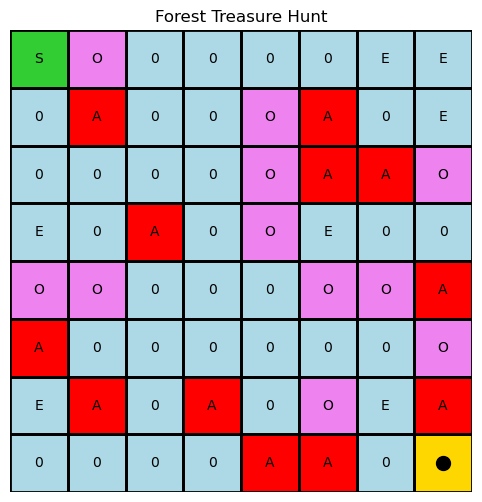

In [4]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import display, clear_output
import time


# generates cost based on type of cell
def generate_cost(type):

   options = [1, 2]
   probabilities = [0.2, 0.8]

   chance = np.random.choice(options, p=probabilities)

   if type=='A':
        if chance==1:
            return np.random.choice([3])
        else:
            return np.random.choice([4])
   elif type=='O':
        return np.random.choice([3])
   elif type=='E':
        return 2
   else:
        return np.random.choice([1])



# Func to calc Manhattan distance

def manhattan_distance(current_pos, target_pos):
    return abs(current_pos[0] - target_pos[0]) + abs(current_pos[1] - target_pos[1])


# Func to generate a matrix 2D for storing cell type and cost while another dimension for storing manhattan distances.
def generate_matrix(size):
    matrix = np.zeros((size, size, 3), dtype=object)

    # Start position
    start_pos = (7, 0)

    # Target cell / Treasure
    target_pos = (0, 7)

    # Assign start and target cells
    matrix[start_pos[0], start_pos[1], 0] = "S"
    matrix[target_pos[0], target_pos[1], 0] = "T"

    # Generate random costs, obstacles, animals, and endpoints
    for i in range(size):
        for j in range(size):
            if (i, j) != start_pos and (i, j) != target_pos:
                if np.random.rand() < 0.15:  # 15% chance for obstacles
                    matrix[i, j, 0] = "O"
                    matrix[i,j,1]=generate_cost('A')
                elif np.random.rand() < 0.10:  # 10% chance for endpoints
                    matrix[i, j, 0] = "E"
                    matrix[i,j,1]=generate_cost('E')
                elif np.random.rand() < 0.25:  # 25% chance for animals
                    matrix[i, j, 0] = "A"
                    if np.random.rand() < 0.5:  # 20% chance for survival
                         matrix[i,j,1]=generate_cost('A')
                    else:
                         matrix[i,j,1]=generate_cost('A')
                else:
                     matrix[i,j,1]=generate_cost('0')

            # Calculate Manhattan distance heuristic
            matrix[i, j, 2] = manhattan_distance((i, j), target_pos)

    return matrix

# Func to perform A* search
def astar(matrix, start, target):
    size = matrix.shape[0]
    visited = set()
    
    # Priority queue (priority, cost, node, path)
    pq = [(0 + matrix[start[0], start[1], 2], 0, start, [])]  
    total_cost = float('inf')  # Initialize total cost to infinity

    while pq:
        _, cost, node, path = heapq.heappop(pq)

        if node == target:
            # Update total cost when the treasure is found
            total_cost = cost  
            return path, total_cost

        if node in visited:
            continue

        visited.add(node)

        row, col = node
        cell_info = matrix[row, col]
        cell_cost = cell_info[1]
        cell_entity = cell_info[0]

        if cell_entity == "E":
        # Skip expanding neighbors if the current cell is an endpoint
            continue  

        neighbors = [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
        for neighbor_row, neighbor_col in neighbors:
            if 0 <= neighbor_row < size and 0 <= neighbor_col < size:
                if (neighbor_row, neighbor_col) not in visited:
                    heuristic = manhattan_distance((neighbor_row, neighbor_col), target)
                    heapq.heappush(pq, (cell_cost + heuristic, cost + cell_cost, (neighbor_row, neighbor_col), path + [(neighbor_row, neighbor_col)]))

    # if no path for the target exists
    return None, total_cost  



# Func to perform Uniform Cost Search
def ucs(matrix, start, target):
    size = matrix.shape[0]
    visited = set()
   
    # Priority queue (cost, node, path)
    pq = [(0, start, [])] 

    while pq:
        cost, node, path = heapq.heappop(pq)

        if node == target:
            return path, cost

        if node in visited:
            continue

        visited.add(node)

        row, col = node
        cell_info = matrix[row, col]
        cell_cost = cell_info[1]
        cell_entity = cell_info[0]

        if cell_entity == "E":
            print("Entered E")
            if len(path) >= 3:  # Check if there are at least 3 nodes in the path
                new_start = path[-3]  # Backtracking two steps
                new_start_row, new_start_col = new_start
                new_pq = [(0, new_start, [])]  # then performs ucs again from that pos, so new queue
                new_visited = set()
                while new_pq:
                    new_cost, new_node, new_path = heapq.heappop(new_pq)
                    if new_node == target:
                        path = path[:-2] + new_path  # Combines old path with new path
                        cost = cost + 1 + new_cost  # Update the total cost
                        continue  # Skip to avoid endpoint in optimal path
                    if new_node in new_visited:
                        continue
                    new_visited.add(new_node)
                    new_row, new_col = new_node
                    new_cell_info = matrix[new_row, new_col]
                    new_cell_cost = new_cell_info[1]
                    new_cell_entity = new_cell_info[0]
                    if new_cell_entity != "E":  # Avoid endpoints in the future path
                        neighbors = [(new_row - 1, new_col), (new_row + 1, new_col), (new_row, new_col - 1), (new_row, new_col + 1)]
                        for neighbor_row, neighbor_col in neighbors:
                            if 0 <= neighbor_row < size and 0 <= neighbor_col < size:
                                if (neighbor_row, neighbor_col) not in new_visited:
                                    heapq.heappush(new_pq, (new_cost + new_cell_cost, (neighbor_row, neighbor_col), new_path + [(neighbor_row, neighbor_col)]))
           
            continue  # Skip the rest of the iteration to avoid adding the endpoint to the optimal path

        neighbors = [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
        for neighbor_row, neighbor_col in neighbors:
            if 0 <= neighbor_row < size and 0 <= neighbor_col < size:
                if (neighbor_row, neighbor_col) not in visited:
                    heapq.heappush(pq, (cost + cell_cost, (neighbor_row, neighbor_col), path + [(neighbor_row, neighbor_col)]))

# 8*8 matrix
size = 8

# Generate the matrix
matrix = generate_matrix(size)

# Create a numerical array for visualization
visualization_matrix = np.zeros((size, size))

# Assign numerical values based on entities or costs
for i in range(size):
    for j in range(size):
        if matrix[i, j, 0] == "S":
            visualization_matrix[i, j] = 1  # Start cell
        elif matrix[i, j, 0] == "T":
            visualization_matrix[i, j] = 2  # Target cell
        elif matrix[i, j, 0] == "O":
            visualization_matrix[i, j] = 3  # Obstacles
        elif matrix[i, j, 0] == "A":
            visualization_matrix[i, j] = 4  # Animals
        else:
            visualization_matrix[i, j] = 0  # Safe points
# Define custom colors for visualization of certain cells
colors = ['lightblue', 'limegreen', 'gold', 'violet', 'red']


# start and target positions
start_pos = (7, 0)
target_pos = (0, 7)


# Create a custom colormap
cmap = ListedColormap(colors)

# Create a figure for the initial visualization
plt.figure(figsize=(8, 6))
plt.imshow(visualization_matrix, cmap=cmap, origin='lower')

# Added black borders around each cell
for i in range(size):
    for j in range(size):
        plt.plot([j - 0.5, j + 0.5], [i - 0.5, i - 0.5], color='black', lw=2)  # Top border
        plt.plot([j - 0.5, j + 0.5], [i + 0.5, i + 0.5], color='black', lw=2)  # Bottom border
        plt.plot([j - 0.5, j - 0.5], [i - 0.5, i + 0.5], color='black', lw=2)  # Left border
        plt.plot([j + 0.5, j + 0.5], [i - 0.5, i + 0.5], color='black', lw=2)  # Right border

# Add annotations for cell types
for i in range(size):
    for j in range(size):
        if matrix[i, j, 0] is not None:
            plt.text(j, i, matrix[i, j, 0], ha='center', va='center', color='black')

# Add a black dot at the start cell 
#traveller
start_dot, = plt.plot(start_pos[1], start_pos[0], 'ko', markersize=10)

plt.title('Forest Treasure Hunt')
plt.xlabel('Column')
plt.ylabel('Row')
plt.axis('off')  # Turn off axis

# Display the initial visualization
display(plt.gcf())
time.sleep(0.5)  # delay for better visualisation

# Perform Uniform Cost Search
# Print entities encountered along the optimal path and total cost

path, total_cost=ucs(matrix,start_pos,target_pos)
for node in path:
    row, col=node
    start_dot.set_data(col,row)
    clear_output(wait=True)
    display(plt.gcf())
    time.sleep(0.5)     

print("Optimal path for UCS: ")
for node in path:
    row, col = node
    cell_info = matrix[row, col]
    cell_cost = cell_info[1]
    cell_entity = cell_info[0]
    print(f"At {node}: Cost encountered: {cell_cost}, Entity: {cell_entity}")
print("Total cost : ", total_cost)


